In [4]:
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True --inplace your_notebook.ipynb

[NbConvertApp] WARNING | pattern 'your_notebook.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
 

In [2]:
metadata = {
    "kernelspec": {
        "name": "python3",
        "language": "python",
        "display_name": "Python 3"
    },
    "language_info": {
        "name": "python",
        "version": "3.8.5"
    },
    "widgets": {
        "application/vnd.jupyter.widget-state+json": {
            "state": {},
            "version_major": 2,
            "version_minor": 0
        }
    }
}


In [ ]:
!pip install sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 25.1 MB/s eta 0:00:00


In [ ]:

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, BioGptTokenizer, BioGptForCausalLM
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Load data
train_variants = pd.read_csv("training_variants.csv")
train_text = pd.read_csv("training_text.csv", sep='\|\|', engine='python', header=None, skiprows=1, names=['ID', 'Text'])
train = pd.merge(train_variants, train_text, on='ID', how='inner')


# Remove empty texts
train = train[train['Text'] != ""]

# Ensure labels are between 1 and 9
assert train['Class'].min() == 1 and train['Class'].max() == 9, "Class labels are not in the range 1-9"

# Ensure all text values are strings
train['Text'] = train['Text'].astype(str).fillna("")

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")







In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load BioGPT tokenizer and model for text generation
biogpt_model_name = "microsoft/biogpt"
biogpt_tokenizer = BioGptTokenizer.from_pretrained(biogpt_model_name)
biogpt_model = BioGptForCausalLM.from_pretrained(biogpt_model_name).to(device)


In [ ]:

# Update generate_text with additional parameters
def generate_text(prompt, max_new_tokens=150, temperature=0.7, top_p=0.95):
    inputs = biogpt_tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024).input_ids.to(device)

    try:
        outputs = biogpt_model.generate(
            inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_p=top_p,
            num_return_sequences=1,
            do_sample=True
        )
        return biogpt_tokenizer.decode(outputs[0], skip_special_tokens=True)
    except Exception as e:
        print(f"Generation error: {str(e)}")
        return prompt


In [ ]:
def augment_dataset(df, start_id=3221):
    augmented_data = []
    class_counts = df['Class'].value_counts().sort_values(ascending=True)
    print("Original class distribution:")
    print(class_counts)

    target_multipliers = {
        8: 20, 9: 10, 3: 5, 5: 3, 6: 2,
        2: 1.5, 1: 1.2, 4: 1.1, 7: 1
    }

    current_generated_id = start_id

    for class_id, multiplier in target_multipliers.items():
        # Get original samples for this class
        class_df = df[df['Class'] == class_id]
        original_count = len(class_df)

        # Always keep original samples
        augmented_data.append(class_df)

        # Calculate target including original samples
        target_count = min(int(original_count * multiplier), 1000)
        needed = max(0, target_count - original_count)

        if needed == 0:
            print(f"Class {class_id} already sufficient: {original_count} samples")
            continue

        print(f"Augmenting class {class_id} from {original_count} to {target_count} (+{needed})")
        generated_count = 0
        attempts = 0
        max_attempts = needed * 2

        while generated_count < needed and attempts < max_attempts:
            sample = class_df.sample(1)
            prompt = (
                f"Generate clinical text about {sample['Gene'].values[0]} "
                f"{sample['Variation'].values[0]} for class {class_id}. "
                f"Context: {sample['Text'].values[0][:500]}"
            )

            generated_text = generate_text(prompt)

            if generated_text and generated_text != prompt:
                new_entry = sample.copy()
                new_entry['Text'] = generated_text
                new_entry['Generated_ID'] = current_generated_id
                current_generated_id += 1
                augmented_data.append(new_entry)
                generated_count += 1

            attempts += 1

        print(f"Added {generated_count} new samples for class {class_id} (Total: {original_count + generated_count})")

    final_df = pd.concat(augmented_data)
    print("\nFinal class distribution:")
    print(final_df['Class'].value_counts().sort_values(ascending=True))
    return final_df

In [ ]:
# Augment the dataset while preserving gene-variation relationships
augmented_train = augment_dataset(train)
augmented_train.to_csv('generated_samples_for_oncologist2025.csv', index=False)

In [ ]:
generated_train= pd.read_csv('generated_samples_for_oncologist2025.csv')

In [ ]:
generated_train.rename(columns={'generated ID': 'ID'}, inplace=True)


In [ ]:
augmented_train = pd.concat([train, generated_train], ignore_index=True)


In [ ]:
def basic_stats(df):
    print("Dataset Shape", df.shape)
    print(f"\nMissing Vlaues: \n{df.isnull().sum()} ")
    print(f"\nClass Distribution:{df['Class'].value_counts().sort_index()}")

    #Gene statistics
    print("\nNumber of unique genes: ", df['Gene'].nunique())
    print(f"\nTop 10 most common genes:{df['Gene'].value_counts().head(10)} ")

    #Variation statistics
    print(f"\nNumber of unique variations:{df['Variation'].nunique()}")
    print(f"\nTop 10 most common variations: {df['Variation'].value_counts().head(10)}")

print("=== Basic Statistics ===")
basic_stats(train)

In [ ]:


# Count the occurrences of each class label
class_counts = train['Class'].value_counts()

class_counts

Class
7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: count, dtype: int64

In [ ]:

# Count the occurrences of each class label
class_counts = augmented_train['Class'].value_counts()

class_counts

,count
Class,
7,953
4,754
5,726
1,681
2,678
6,550
3,445
8,380
9,370


In [ ]:

# Split the augmented data

# Split dataset into training and validation sets (80-20 split)
augment_texts, valaug_texts, augment_labels, valaug_labels = train_test_split(
    augmented_train['Text'],
    augmented_train['Class'],
    test_size=0.2,
    stratify=augmented_train['Class'],
    random_state=42
)


In [ ]:
# Load BioBERT tokenizer and model
model_name = 'monologg/biobert_v1.1_pubmed'
tokenizer = BertTokenizer.from_pretrained(model_name)

# Add missing terms to tokenizer
missing_terms = ["dna", "fig", "missense", "mutants", "supplementary"]
tokenizer.add_tokens(missing_terms)

pretrained_model = BertForSequenceClassification.from_pretrained(model_name, num_labels=9).to(device)
pretrained_model.resize_token_embeddings(len(tokenizer))




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/biobert_v1.1_pubmed and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(29001, 768, padding_idx=0)

# gradual unfreezing

In [ ]:

# Unfreeze last few layers for fine-tuning
def unfreeze_layers1(model, num_epochs, freeze_at_epoch=7):
    for name, param in model.named_parameters():
        # Initially freeze all layers
        param.requires_grad = False

    # Unfreeze layers gradually after certain epochs
    if num_epochs > freeze_at_epoch:
        for name, param in model.named_parameters():
            if 'encoder.layer.10' in name or 'encoder.layer.11' in name:  # Example for unfreezing last layers
                param.requires_grad = True

    return model


In [ ]:
import torch.nn as nn # Import the nn module from PyTorch
import torch.nn.functional as F
# Weighted Focal Loss
class WeightedFocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2, device='cuda'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.device = device

    def forward(self, inputs, targets):
        targets = targets.to(self.device)
        ce_loss = F.cross_entropy(inputs, targets.long(), reduction="none")  # Ensure targets are long
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        weighted_loss = focal_loss * class_weights[targets]
        return weighted_loss.mean()

# Define loss function
loss_fn = WeightedFocalLoss(alpha=0.5, gamma=3, device=device)

In [ ]:
# Custom Trainer class
class CustomLossTrainer(Trainer):
    def __init__(self, *args, loss_fn=None, **kwargs):
        super().__init__(*args, **kwargs)
        if loss_fn is None:
            raise ValueError("A custom loss function must be provided!")
        self.loss_fn = loss_fn
        self.label_names = ["labels"]
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss = self.loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [ ]:
# Dataset class
class MutationDataset(Dataset):
    def __init__(self, texts, labels):
        # Convert texts to a list of strings if it's not already
        if not isinstance(texts, list):
            texts = texts.tolist()  # Convert Series or other objects to a list

        self.encodings = tokenizer(
            texts, truncation=True, padding="max_length", max_length=512, return_tensors='pt', return_token_type_ids=False,
        )
        # Convert 1-9 to 0-8 for each label in the list using list comprehension
        self.labels = [label - 1 for label in labels]


    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)  # Ensure dtype is long
        }

    def __len__(self):
        return len(self.labels)

# Create train and validation datasets
train_dataset = MutationDataset(augment_texts, augment_labels)
val_dataset = MutationDataset(valaug_texts, valaug_labels)


In [ ]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Eval dataset size: {len(val_dataset)}")


Train dataset size: 4429
Eval dataset size: 1108


In [ ]:
print("🚨 Final check before training 🚨")
print(f"👉 Type of train_dataset: {type(train_dataset)}")
print(f"👉 Type of val_dataset: {type(val_dataset)}")
print(f"✅ Length of train_dataset: {len(train_dataset)}")
print(f"✅ Length of val_dataset: {len(val_dataset)}")
print(f"👀 Sample val_dataset[0]: {val_dataset[0]}")


In [ ]:

# Compute class weights
labels_array = np.array(augment_labels) - 1  # Convert train_labels to a NumPy array before subtraction
classes = np.unique(labels_array)
cw = compute_class_weight('balanced', classes=classes, y=labels_array)
class_weights = torch.tensor(cw, dtype=torch.float).to(device)
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=11,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    eval_strategy='epoch',
    fp16=True,
    logging_dir='./logs',
    report_to='none',
    dataloader_pin_memory=True,
    save_strategy='epoch',
    gradient_accumulation_steps=1,
    ddp_find_unused_parameters=False
)

# Reload model for each fold and unfreeze layers gradually
pretrained_model = BertForSequenceClassification.from_pretrained(model_name, num_labels=9).to(device)
pretrained_model.resize_token_embeddings(len(tokenizer))

#Unfreeze layers after certain epochs
pretrained_model = unfreeze_layers1(pretrained_model, num_epochs=30)


# Trainer
trainer = CustomLossTrainer(
    model=pretrained_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=lambda p: {
        'accuracy': accuracy_score(p.label_ids, p.predictions.argmax(-1)),
        'f1': f1_score(p.label_ids, p.predictions.argmax(-1), average='weighted'),
        'precision': precision_score(p.label_ids, p.predictions.argmax(-1), average='weighted'),
        'recall': recall_score(p.label_ids, p.predictions.argmax(-1), average='weighted')
    },
    loss_fn=loss_fn
)

# Train & Evaluate
trainer.train()
results = trainer.evaluate()
print("Validation Results:", results)


# Save the model weights and configuration
trainer.save_model('./results')

# In your training script after tokenizer modifications
tokenizer.save_pretrained('./results')  # Save modified tokenizer with custom tokens



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/biobert_v1.1_pubmed and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-11-78ce3af2793f>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.647000,0.533928,0.359206,0.324369,0.407530,0.359206
2,0.251800,0.198016,0.718412,0.725534,0.747111,0.718412
3,0.190500,0.190263,0.738267,0.738620,0.791971,0.738267
4,0.151900,0.163750,0.746390,0.747580,0.754490,0.746390
5,0.141700,0.153458,0.750903,0.754599,0.766669,0.750903
6,0.125200,0.151880,0.746390,0.749548,0.764595,0.746390
7,0.113900,0.149940,0.752708,0.753587,0.758219,0.752708
8,0.107600,0.149550,0.771661,0.771617,0.779021,0.771661
9,0.098600,0.148009,0.767148,0.769352,0.777188,0.767148
10,0.102900,0.149783,0.761733,0.761975,0.766518,0.761733


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validation Results: {'eval_loss': 0.14927758276462555, 'eval_accuracy': 0.7626353790613718, 'eval_f1': 0.7634047602360655, 'eval_precision': 0.7673575697734085, 'eval_recall': 0.7626353790613718, 'eval_runtime': 8.7812, 'eval_samples_per_second': 126.179, 'eval_steps_per_second': 31.545, 'epoch': 11.0}


('./results/tokenizer_config.json',
 './results/special_tokens_map.json',
 './results/vocab.txt',
 './results/added_tokens.json')

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np
from tqdm import tqdm
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load FINE-TUNED model and tokenizer with clear naming
model_path = './results'
bert_tokenizer = BertTokenizer.from_pretrained(model_path)
bert_model = BertForSequenceClassification.from_pretrained(model_path).to(device)

def clear_memory():
    torch.cuda.empty_cache()
    gc.collect()

def get_embeddings_batched(texts, batch_size=16):
    """Get [CLS] embeddings using fine-tuned BERT"""
    bert_model.eval()  # Set to evaluation mode
    embeddings = []

    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size)):
            batch = texts[i:i+batch_size]

            # Tokenize with BERT tokenizer
            inputs = bert_tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=512,
                return_tensors="pt"
            ).to(device)

            # Get hidden states from BERT base
            outputs = bert_model.bert(**inputs)

            # Extract CLS embeddings
            cls_emb = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_emb)

            # Clean memory
            del inputs, outputs
            clear_memory()

    return np.vstack(embeddings)

# Usage
clear_memory()

In [ ]:
from sklearn.preprocessing import LabelEncoder
import joblib
# Label encode categorical features
le_gene = LabelEncoder()
le_variation = LabelEncoder()


augmented_train['Gene_encoded'] = le_gene.fit_transform(augmented_train['Gene'])
joblib.dump(le_gene, 'gene_label_encoder.pkl')  # Save for later

augmented_train['Variation_encoded'] = le_variation.fit_transform(augmented_train['Variation'])
joblib.dump(le_variation, 'variation_label_encoder.pkl')  # Save for later

['variation_label_encoder.pkl']

<ipython-input-30-b50bf7303a8e>:23: UserWarning: 
The markers list has fewer values (1) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x='PCA1', y='PCA2', hue='KMeans', palette='tab10', data=umap_df, style='KMeans', markers='o')


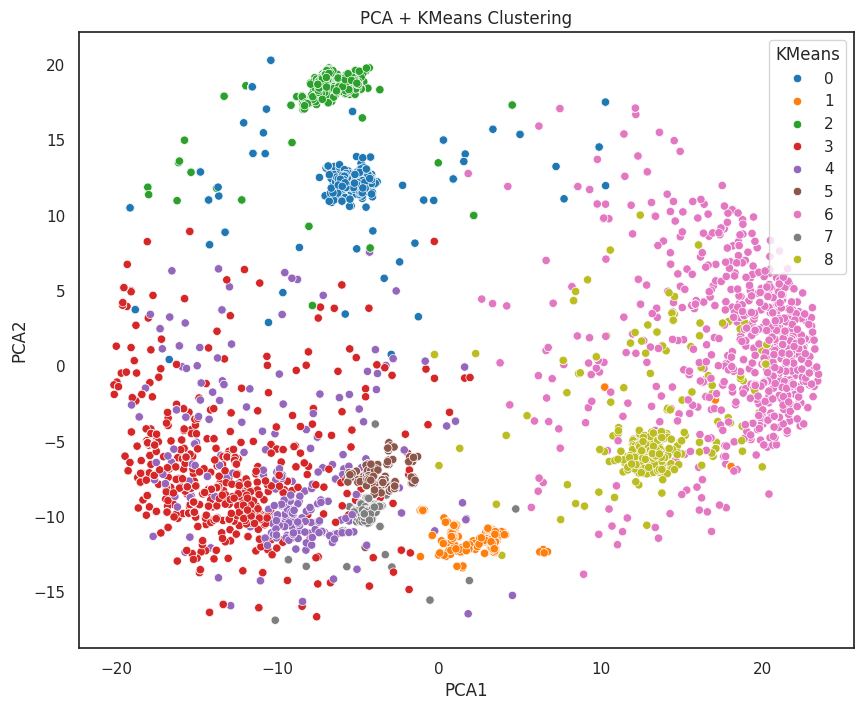

<ipython-input-30-b50bf7303a8e>:29: UserWarning: 
The markers list has fewer values (1) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x='PCA1', y='PCA2', hue='Class', palette='tab10', data=umap_df, style='Class', markers='x')


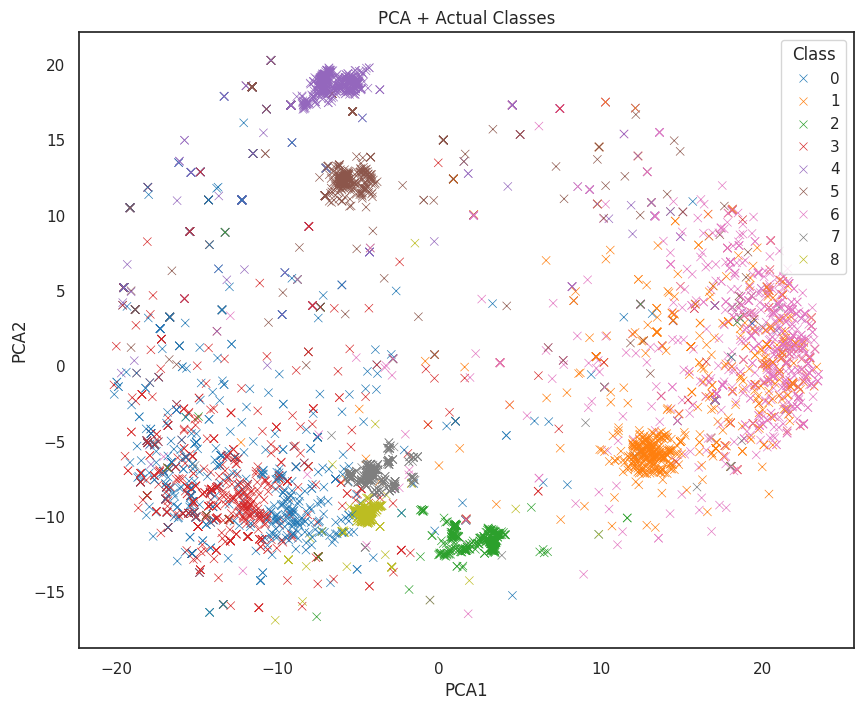

In [ ]:
# Optionally, standardize the data (important for KMeans)
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

# Apply KMeans clustering (e.g., 9 clusters as you mentioned)
kmeans = KMeans(n_clusters=9, random_state=42)
kmeans_labels = kmeans.fit_predict(X_all_scaled)

# Add the KMeans cluster labels to the DataFrame
augmented_train['KMeans'] = kmeans_labels

# Use PCA for dimensionality reduction to visualize the clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all_scaled)

# Create a DataFrame for plotting
umap_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
umap_df['KMeans'] = augmented_train['KMeans']
umap_df['Class'] = augmented_train['Class']

# Plot KMeans clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='KMeans', palette='tab10', data=umap_df, style='KMeans', markers='o')
plt.title('PCA + KMeans Clustering')
plt.show()

# Plot the actual class labels for comparison
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Class', palette='tab10', data=umap_df, style='Class', markers='x')
plt.title('PCA + Actual Classes')
plt.show()

In [ ]:



# Ensure classes are 0-based
augmented_train['Class'] = augmented_train['Class'] - 1  # If classes start at 1

# Generate embeddings for the entire augmented dataset
all_embeddings = get_embeddings_batched(augmented_train['Text'].tolist(), batch_size=16)

# Now create X_all using the entire augmented_train DataFrame
X_all = np.hstack([all_embeddings, augmented_train[['Gene_encoded', 'Variation_encoded']].values])
y_all = augmented_train['Class'].values # Use values to get a NumPy array




100%|██████████| 347/347 [15:04<00:00,  2.61s/it]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


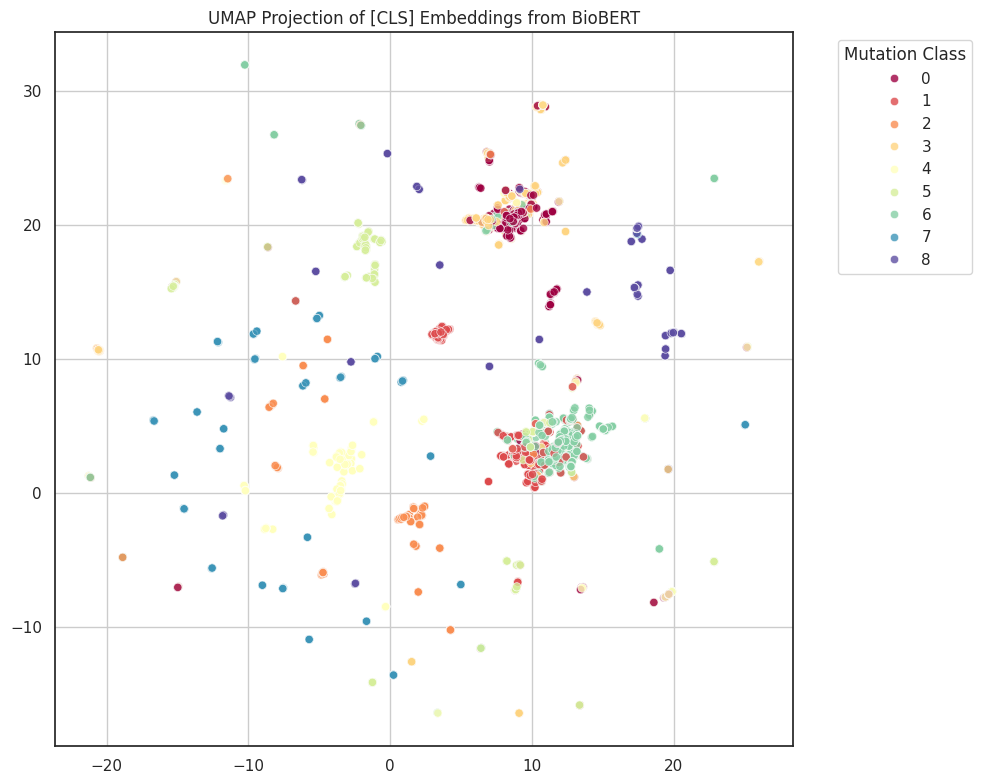

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
import seaborn as sns

# Set seaborn style for better visuals
sns.set(style='white', context='notebook')

# Run UMAP on just the [CLS] embeddings
reducer = umap.UMAP(n_components=2, random_state=42)
embedding_umap = reducer.fit_transform(all_embeddings)

# Create a DataFrame for plotting
umap_df = pd.DataFrame({
    'UMAP1': embedding_umap[:, 0],
    'UMAP2': embedding_umap[:, 1],
    'Class': y_all  # Classes are already 0-based
})

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='UMAP1', y='UMAP2',
    hue='Class',
    palette='Spectral',
    data=umap_df,
    legend='full',
    alpha=0.8
)
plt.title('UMAP Projection of [CLS] Embeddings from BioBERT')
plt.xlabel('')
plt.ylabel('')
plt.grid(True)
plt.legend(title='Mutation Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<ipython-input-29-827d828a1483>:14: UserWarning: 
The markers list has fewer values (1) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x='UMAP1', y='UMAP2', hue='KMeans', palette='tab10', data=umap_df, style='KMeans', markers='o')


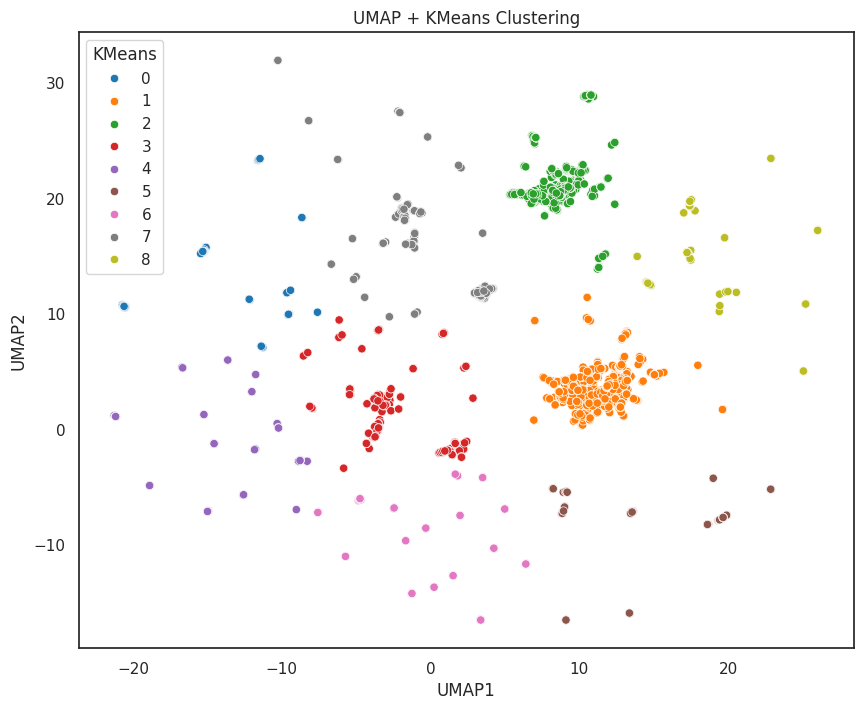

<ipython-input-29-827d828a1483>:20: UserWarning: 
The markers list has fewer values (1) than needed (9) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x='UMAP1', y='UMAP2', hue='Class', palette='tab10', data=umap_df, style='Class', markers='x')


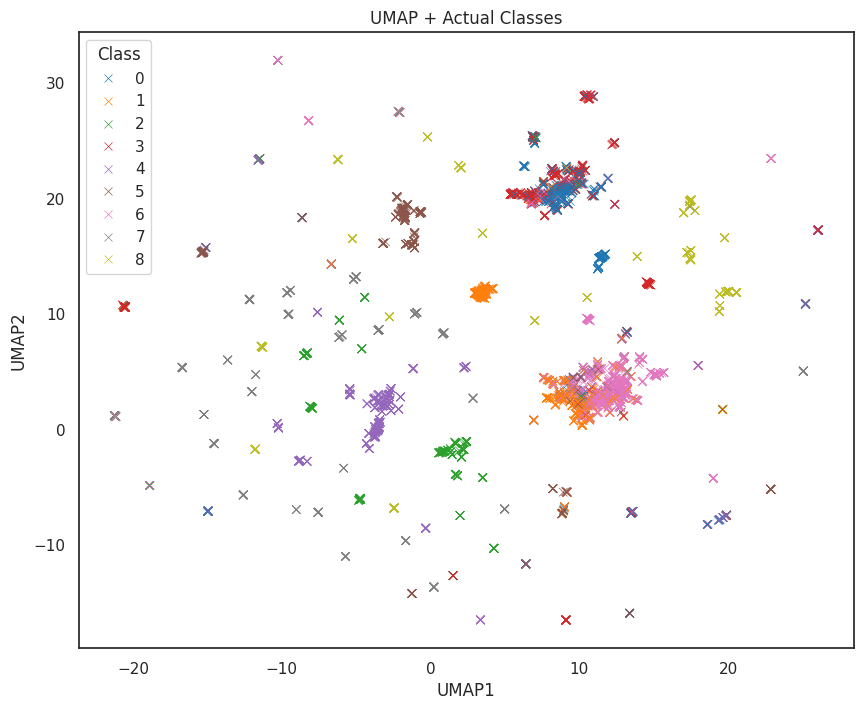

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd

# Assuming you already have `embedding_umap` (your 2D UMAP embeddings) and `umap_df` (your DataFrame containing 'UMAP1', 'UMAP2' columns)

# Apply KMeans clustering with 9 clusters
kmeans = KMeans(n_clusters=9, random_state=42)
umap_df['KMeans'] = kmeans.fit_predict(embedding_umap)

# Plot KMeans clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='KMeans', palette='tab10', data=umap_df, style='KMeans', markers='o')
plt.title('UMAP + KMeans Clustering')
plt.show()

# Plot the actual classes
plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Class', palette='tab10', data=umap_df, style='Class', markers='x')
plt.title('UMAP + Actual Classes')
plt.show()


In [ ]:
# Add these imports at the top
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_all and y_all are your features and labels
X = X_all  # Shape (5000, n_features)
y = y_all  # Shape (5000,)

# ========== CRUCIAL FIX ==========
# Validate and remap labels to 0-based indexing
unique_classes = np.unique(y)
print(f"Original classes: {unique_classes}")

# Create label mapping (e.g., [1,2,3] -> [0,1,2])
label_mapping = {orig: new for new, orig in enumerate(unique_classes)}
y_remapped = np.vectorize(label_mapping.get)(y)

# Verify new labels
print(f"Remapped classes: {np.unique(y_remapped)}")
num_classes = len(unique_classes)
# =================================


# Add this section AFTER label remapping but BEFORE initializing KFold
# ========== Hyperparameter Tuning ==========
print("\nStarting hyperparameter optimization...")

# Parameter space
param_dist = {
    'max_depth': randint(3, 6),
    'learning_rate': uniform(0.05, 0.15),  # 0.05-0.2
    'subsample': uniform(0.7, 0.2),        # 0.7-0.9
    'colsample_bytree': uniform(0.7, 0.2),
    'reg_alpha': uniform(0, 1),            # 0-1
    'reg_lambda': uniform(0.5, 1),         # 0.5-1.5
    'gamma': uniform(0, 0.3),              # 0-0.3
    'min_child_weight': randint(1, 5)
}

# Create base model
xgb_tune = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=num_classes,
    tree_method='hist',
    random_state=42
)

# Randomized search
search = RandomizedSearchCV(
    estimator=xgb_tune,
    param_distributions=param_dist,
    n_iter=50,            # Number of parameter combinations
    scoring='neg_log_loss',
    cv=KFold(n_splits=3, shuffle=True, random_state=42),  # Faster 3-fold
    verbose=2,
    n_jobs=-1
)

# Run search on 80% of data to keep 20% for validation
tune_idx, _ = next(KFold(n_splits=5, shuffle=True, random_state=42).split(X))
search.fit(X[tune_idx], y_remapped[tune_idx])

# Get best parameters
best_params = search.best_params_
print(f"\nBest parameters: {best_params}")
print(f"Best validation log loss: {-search.best_score_:.4f}")

# Update main parameters
params.update({
    'max_depth': best_params['max_depth'],
    'learning_rate': best_params['learning_rate'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'reg_alpha': best_params['reg_alpha'],
    'reg_lambda': best_params['reg_lambda'],
    'gamma': best_params['gamma'],
    'min_child_weight': best_params['min_child_weight']
})

# ========== Proceed with original CV below ==========
# Assuming X_all and y_all are your features and labels
X = X_all  # Shape (5000, n_features)
y = y_all  # Shape (5000,)

# Initialize components
scaler = StandardScaler()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

# For storing metrics across all folds
y_true_all = []
y_pred_all = []
y_proba_all = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nFold {fold + 1}")

    # Split data
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_remapped[train_idx], y_remapped[val_idx]

    # Scale features
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Create DMatrix objects
    dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
    dval = xgb.DMatrix(X_val_scaled, label=y_val)

    # Updated XGBoost parameters with regularization
    params = {
        'objective': 'multi:softprob',
        'num_class': num_classes,
        'tree_method': 'hist',
        'max_depth': 3,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,

        # Regularization parameters added
        'reg_alpha': 0.8,   # L1 regularization (alpha)
        'reg_lambda': 0.5,  # L2 regularization (lambda)
        'gamma': 0.1,       # Minimum loss reduction for split

        # Additional tree parameters
        'min_child_weight': 3,
        'max_delta_step': 2
    }

    # Train model
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=200,
        evals=[(dtrain, 'train'), (dval, 'val')],
        early_stopping_rounds=20,
        verbose_eval=50
    )

    # Predictions
    y_pred_proba = model.predict(dval)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Store for overall metrics
    y_true_all.extend(y_val)
    y_pred_all.extend(y_pred)
    y_proba_all.extend(y_pred_proba)

    # Calculate metrics
    fold_metrics = {
        'log_loss': log_loss(y_val, y_pred_proba),
        'accuracy': accuracy_score(y_val, y_pred),
        'f1_macro': f1_score(y_val, y_pred, average='macro'),
        'f1_weighted': f1_score(y_val, y_pred, average='weighted')
    }

    print(f"\nFold {fold + 1} Evaluation:")
    for metric, value in fold_metrics.items():
        print(f"{metric}: {value:.4f}")

    fold_results.append(fold_metrics)

# ========== Overall Metrics ==========
# Convert to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)
y_proba_all = np.array(y_proba_all)

# 1. Confusion Matrix
cm = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_classes,
            yticklabels=unique_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 2. ROC AUC (One-vs-Rest)
roc_auc = roc_auc_score(y_true_all, y_proba_all, multi_class='ovr')
print(f"\nOverall ROC AUC (OvR): {roc_auc:.4f}")

# 3. Precision-Recall Curve (Fixed)
from sklearn.preprocessing import label_binarize

# Binarize the true labels for multiclass PR curves
y_true_bin = label_binarize(y_true_all, classes=range(num_classes))

precision = dict()
recall = dict()
average_precision = dict()

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(
        y_true_bin[:, i],
        y_proba_all[:, i]
    )
    average_precision[i] = auc(recall[i], precision[i])

# Micro-average calculation
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_true_bin.ravel(),
    y_proba_all.ravel()
)
average_precision["micro"] = auc(recall["micro"], precision["micro"])

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(recall[i], precision[i],
             label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.plot(recall["micro"], precision["micro"],
         label=f'Micro-average (AP = {average_precision["micro"]:.2f})',
         color='gold', linestyle=':')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# 4. Classification Report
print("\nClassification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=[str(c) for c in unique_classes]))

# Cross-validation summary
print("\n" + "=" * 40)
print("Final Cross-Validation Results:")
print("=" * 40)
for metric in ['log_loss', 'accuracy', 'f1_macro', 'f1_weighted']:
    scores = [res[metric] for res in fold_results]
    print(f"{metric:15}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# ========== Feature Importance ==========
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, importance_type='weight')
plt.title('Feature Importance (F-score)')
plt.show()


Original classes: [0 1 2 3 4 5 6 7 8]
Remapped classes: [0 1 2 3 4 5 6 7 8]

Starting hyperparameter optimization...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


KeyboardInterrupt: 

Original classes: [0 1 2 3 4 5 6 7 8]
Remapped classes: [0 1 2 3 4 5 6 7 8]

Fold 1
[0]	train-mlogloss:2.10158	val-mlogloss:2.10549
[50]	train-mlogloss:0.49288	val-mlogloss:0.59183
[100]	train-mlogloss:0.33887	val-mlogloss:0.47760
[150]	train-mlogloss:0.29251	val-mlogloss:0.46839
[159]	train-mlogloss:0.28675	val-mlogloss:0.46874

Fold 1 Evaluation:
log_loss: 0.4689
accuracy: 0.8231
f1_macro: 0.8450
f1_weighted: 0.8248

Fold 2
[0]	train-mlogloss:2.10207	val-mlogloss:2.10408
[50]	train-mlogloss:0.49048	val-mlogloss:0.58499
[100]	train-mlogloss:0.33628	val-mlogloss:0.48438
[145]	train-mlogloss:0.29485	val-mlogloss:0.48088

Fold 2 Evaluation:
log_loss: 0.4809
accuracy: 0.8222
f1_macro: 0.8434
f1_weighted: 0.8226

Fold 3
[0]	train-mlogloss:2.10141	val-mlogloss:2.10550
[50]	train-mlogloss:0.49718	val-mlogloss:0.57888
[100]	train-mlogloss:0.34294	val-mlogloss:0.46906
[150]	train-mlogloss:0.29713	val-mlogloss:0.46056
[161]	train-mlogloss:0.29024	val-mlogloss:0.46133

Fold 3 Evaluation:
log_los

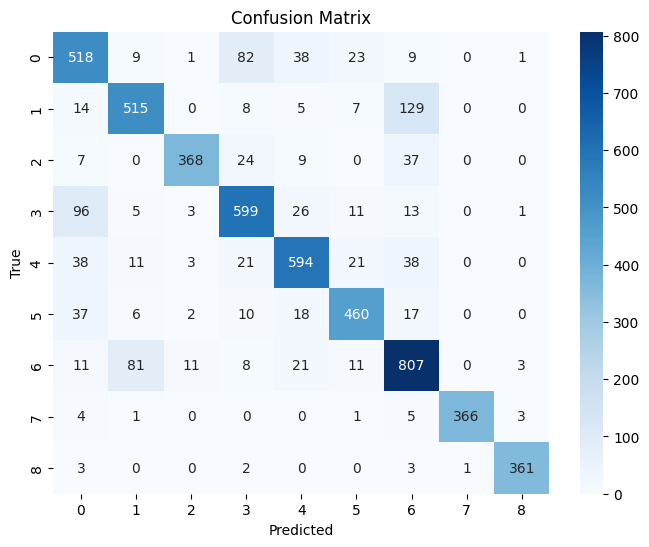


Overall ROC AUC (OvR): 0.9835


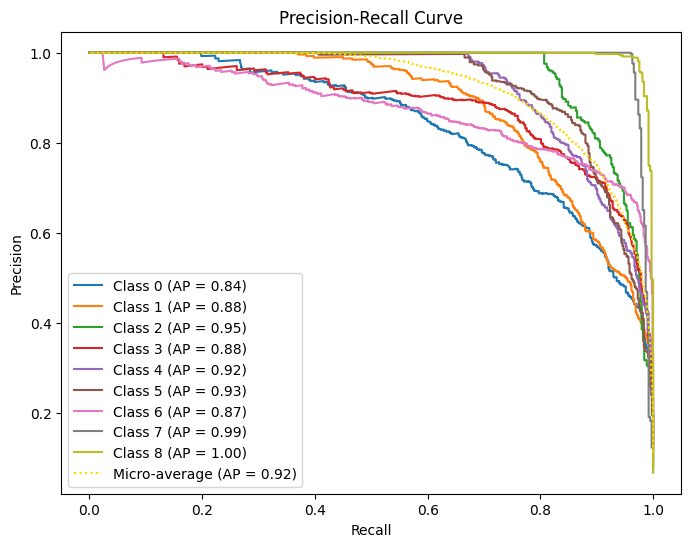


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.76      0.74       681
           1       0.82      0.76      0.79       678
           2       0.95      0.83      0.88       445
           3       0.79      0.79      0.79       754
           4       0.84      0.82      0.83       726
           5       0.86      0.84      0.85       550
           6       0.76      0.85      0.80       953
           7       1.00      0.96      0.98       380
           8       0.98      0.98      0.98       370

    accuracy                           0.83      5537
   macro avg       0.86      0.84      0.85      5537
weighted avg       0.83      0.83      0.83      5537


Final Cross-Validation Results:
log_loss       : 0.4707 ± 0.0173
accuracy       : 0.8286 ± 0.0059
f1_macro       : 0.8485 ± 0.0042
f1_weighted    : 0.8296 ± 0.0058


<Figure size 1000x600 with 0 Axes>

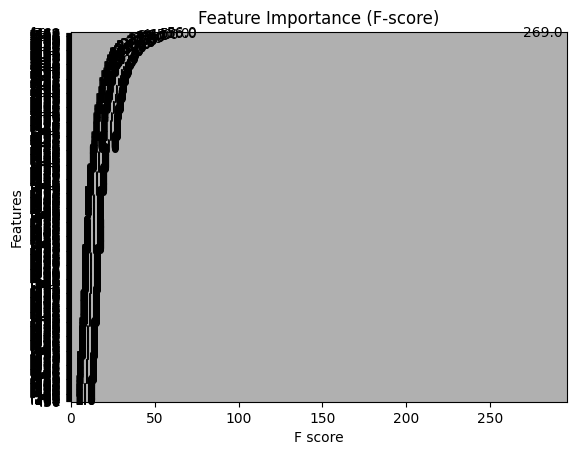

In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import (log_loss, accuracy_score, f1_score,
                             confusion_matrix, classification_report,
                             roc_auc_score, precision_recall_curve, auc)
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_all and y_all are your features and labels
X = X_all  # Shape (5000, n_features)
y = y_all  # Shape (5000,)

# ========== CRUCIAL FIX ==========
# Validate and remap labels to 0-based indexing
unique_classes = np.unique(y)
print(f"Original classes: {unique_classes}")

# Create label mapping (e.g., [1,2,3] -> [0,1,2])
label_mapping = {orig: new for new, orig in enumerate(unique_classes)}
y_remapped = np.vectorize(label_mapping.get)(y)

# Verify new labels
print(f"Remapped classes: {np.unique(y_remapped)}")
num_classes = len(unique_classes)
# =================================

# Initialize components
scaler = StandardScaler()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

# For storing metrics across all folds
y_true_all = []
y_pred_all = []
y_proba_all = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nFold {fold + 1}")

    # Split data
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_remapped[train_idx], y_remapped[val_idx]

    # Scale features
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Create DMatrix objects
    dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
    dval = xgb.DMatrix(X_val_scaled, label=y_val)

    # Updated XGBoost parameters with regularization
    params = {
        'objective': 'multi:softprob',
        'num_class': num_classes,
        'tree_method': 'hist',
        'max_depth': 3,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,

        # Regularization parameters added
        'reg_alpha': 0.8,   # L1 regularization (alpha)
        'reg_lambda': 0.5,  # L2 regularization (lambda)
        'gamma': 0.1,       # Minimum loss reduction for split

        # Additional tree parameters
        'min_child_weight': 3,
        'max_delta_step': 2
    }

    # Train model
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=200,
        evals=[(dtrain, 'train'), (dval, 'val')],
        early_stopping_rounds=20,
        verbose_eval=50
    )

    # Predictions
    y_pred_proba = model.predict(dval)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Store for overall metrics
    y_true_all.extend(y_val)
    y_pred_all.extend(y_pred)
    y_proba_all.extend(y_pred_proba)

    # Calculate metrics
    fold_metrics = {
        'log_loss': log_loss(y_val, y_pred_proba),
        'accuracy': accuracy_score(y_val, y_pred),
        'f1_macro': f1_score(y_val, y_pred, average='macro'),
        'f1_weighted': f1_score(y_val, y_pred, average='weighted')
    }

    print(f"\nFold {fold + 1} Evaluation:")
    for metric, value in fold_metrics.items():
        print(f"{metric}: {value:.4f}")

    fold_results.append(fold_metrics)

# ========== Overall Metrics ==========
# Convert to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)
y_proba_all = np.array(y_proba_all)

# 1. Confusion Matrix
cm = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_classes,
            yticklabels=unique_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 2. ROC AUC (One-vs-Rest)
roc_auc = roc_auc_score(y_true_all, y_proba_all, multi_class='ovr')
print(f"\nOverall ROC AUC (OvR): {roc_auc:.4f}")

# 3. Precision-Recall Curve (Fixed)
from sklearn.preprocessing import label_binarize

# Binarize the true labels for multiclass PR curves
y_true_bin = label_binarize(y_true_all, classes=range(num_classes))

precision = dict()
recall = dict()
average_precision = dict()

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(
        y_true_bin[:, i],
        y_proba_all[:, i]
    )
    average_precision[i] = auc(recall[i], precision[i])

# Micro-average calculation
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_true_bin.ravel(),
    y_proba_all.ravel()
)
average_precision["micro"] = auc(recall["micro"], precision["micro"])

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(recall[i], precision[i],
             label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.plot(recall["micro"], precision["micro"],
         label=f'Micro-average (AP = {average_precision["micro"]:.2f})',
         color='gold', linestyle=':')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# 4. Classification Report
print("\nClassification Report:")
print(classification_report(y_true_all, y_pred_all, target_names=[str(c) for c in unique_classes]))

# Cross-validation summary
print("\n" + "=" * 40)
print("Final Cross-Validation Results:")
print("=" * 40)
for metric in ['log_loss', 'accuracy', 'f1_macro', 'f1_weighted']:
    scores = [res[metric] for res in fold_results]
    print(f"{metric:15}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# ========== Feature Importance ==========
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, importance_type='weight')
plt.title('Feature Importance (F-score)')
plt.show()

In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import pickle

# Assuming X_all and y_all are your features and labels
X = X_all  # Shape (5000, n_features)
y = y_all  # Shape (5000,)

# ========== Label Remapping ==========
unique_classes = np.unique(y)
print(f"Original classes: {unique_classes}")

# Create and apply label mapping
label_mapping = {orig: new for new, orig in enumerate(unique_classes)}
y_remapped = np.vectorize(label_mapping.get)(y)
print(f"Remapped classes: {np.unique(y_remapped)}")
num_classes = len(unique_classes)

# ========== Feature Scaling ==========
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ========== Full Dataset Training ==========
# Create DMatrix for full dataset
dtrain = xgb.DMatrix(X_scaled, label=y_remapped)

# Parameters (keep same as before)
params = {
       'objective': 'multi:softprob',
        'num_class': num_classes,
        'tree_method': 'hist',
        'max_depth': 3,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,

        # Regularization parameters added
        'reg_alpha': 0.8,   # L1 regularization (alpha)
        'reg_lambda': 0.5,  # L2 regularization (lambda)
        'gamma': 0.1,       # Minimum loss reduction for split

        # Additional tree parameters
        'min_child_weight': 3,
        'max_delta_step': 2
}

# Train final model on all data
final_model = xgb.train(
    params,
    dtrain,
    num_boost_round=200  # Use optimal rounds from CV if available
)

# ========== Save Components (JSON version) ==========
# Save the trained model in JSON format
final_model.save_model('xgb_model.json')  # This saves as JSON by default when using .json extension

# Save the scaler and mapping using joblib (better than pickle for sklearn objects)
from joblib import dump

dump(scaler, 'standard_scaler.joblib')
dump(label_mapping, 'label_mapping.joblib')

print("Training completed and components saved in JSON/Joblib format!")

Original classes: [0 1 2 3 4 5 6 7 8]
Remapped classes: [0 1 2 3 4 5 6 7 8]
Training completed and components saved in JSON/Joblib format!


In [ ]:
import pandas as pd
import torch
from tqdm import tqdm
import lightgbm as lgb
import joblib
from transformers import BertTokenizer

# === Main Prediction Pipeline ===
# Load data
test_variants = pd.read_csv("test_variants.csv")
test_text = pd.read_csv("test_text.csv", sep='\|\|', engine='python',  # Specify Python engine
                        names=['ID', 'Text'], skiprows=1, encoding='latin-1')

# Convert ID columns to string type to ensure compatibility
test_variants['ID'] = test_variants['ID'].astype(str)
test_text['ID'] = test_text['ID'].astype(str)

# Merge DataFrames once
test = pd.merge(test_variants, test_text, on='ID')

# === FIX: Remove rows with invalid 'Text' values ===
test = test[test['Text'].apply(lambda x: isinstance(x, str) and bool(x.strip()))]

In [ ]:
augmented_train

,ID,Gene,Variation,Class,Text,Generated_ID,Gene_encoded,Variation_encoded,KMeans
0,0.0,FAM58A,Truncating Mutations,0,Cyclin-dependent kinases (CDKs) regulate a var...,NaN,85,2629,3
1,1.0,CBL,W802*,1,Abstract Background Non-small cell lung canc...,NaN,39,2856,6
2,2.0,CBL,Q249E,1,Abstract Background Non-small cell lung canc...,NaN,39,1897,6
3,3.0,CBL,N454D,2,Recent evidence has demonstrated that acquired...,NaN,39,1667,3
4,4.0,CBL,L399V,3,Oncogenic mutations in the monomeric Casitas B...,NaN,39,1447,2
...,...,...,...,...,...,...,...,...,...
5532,NaN,SMAD3,V277D,3,Generate a detailed genomic testing report for...,5432.0,231,2700,3
5533,NaN,BRCA1,W1718C,3,Generate a detailed clinical trial assessment ...,5433.0,31,2816,3
5534,NaN,NF1,R1276Q,3,Generate a detailed clinical trial assessment ...,5434.0,162,1976,3
5535,NaN,TP53,C242S,3,Generate a detailed oncology consultation note...,5435.0,252,194,3


In [ ]:
test

,ID,Gene,Variation,Text
0,0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...
1,1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,PAH,L333F,Vascular endothelial growth factor receptor (V...
3,3,ING1,A148D,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,TMEM216,G77A,Abstract Retinoblastoma is a pediatric retina...
...,...,...,...,...
5658,5663,SLC46A1,R113S,The realization in the late 1970s that RAS har...
5659,5664,FOXC1,L130F,Hemizygous deletions are common molecular abno...
5660,5665,GSS,R267W,All most R267W of has with to SMARTpool invest...
5661,5666,CTSK,G79E,Abstract Blood samples from 125 unrelated fami...


In [ ]:
import pandas as pd
import torch
from tqdm import tqdm
import lightgbm as lgb
import joblib
from transformers import BertTokenizer

# === Main Prediction Pipeline ===
# Load data
test_variants = pd.read_csv("test_variants.csv")
test_text = pd.read_csv("test_text.csv", sep='\|\|', engine='python',  # Specify Python engine
                        names=['ID', 'Text'], skiprows=1, encoding='latin-1')

# Convert ID columns to string type to ensure compatibility
test_variants['ID'] = test_variants['ID'].astype(str)
test_text['ID'] = test_text['ID'].astype(str)

# Merge DataFrames once
test = pd.merge(test_variants, test_text, on='ID')

# === FIX: Remove rows with invalid 'Text' values ===
test = test[test['Text'].apply(lambda x: isinstance(x, str) and bool(x.strip()))]

# Generate BERT embeddings (assuming get_embeddings_batched is defined)
text_embeddings = get_embeddings_batched(test['Text'].tolist())

# Load encoders and encode features
le_gene = joblib.load('gene_label_encoder.pkl')
le_variation = joblib.load('variation_label_encoder.pkl')

test['Gene_encoded'] = test['Gene'].apply(lambda x: le_gene.transform([x])[0] if x in le_gene.classes_ else -1)
test['Variation_encoded'] = test['Variation'].apply(lambda x: le_variation.transform([x])[0] if x in le_variation.classes_ else -1)

# Combine features
import numpy as np
X_test = np.hstack([
    text_embeddings,
    test[['Gene_encoded', 'Variation_encoded']].values
])

# Apply scaling
scaler = joblib.load('standard_scaler.joblib')
X_test_scaled = scaler.transform(X_test)

# Make predictions
xgb_model = xgb.Booster()
xgb_model.load_model('xgb_model.json')
dtest = xgb.DMatrix(X_test_scaled)
test_probs = xgb_model.predict(dtest)

# Re-map probabilities to original class order
label_mapping = joblib.load('label_mapping.joblib')
original_classes = sorted(label_mapping.keys())
submission_probs = test_probs[:, np.argsort(original_classes)]

# Create submission
submission = pd.DataFrame({
    'ID': test['ID'],
    **{f'Class{cls}': submission_probs[:, i]
       for i, cls in enumerate(sorted(original_classes))}
})
submission.to_csv('submission.csv', index=False)



100%|██████████| 354/354 [23:31<00:00,  3.99s/it]
